In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy, os, glob, sys, re
import matplotlib.ticker as mtick

In [2]:
sys.path.append('/'.join(os.path.realpath('..').split('/')[:4]) + '/Python')
import FigureTools

In [3]:
base_dir = os.path.realpath('../..')
print(base_dir)

/Users/jeroen/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Code_share/NHB_motives_structure/Study1_MTurk


In [4]:
gameDat = pd.read_csv(base_dir + '/Data/Cleaned/gameDat.csv',
                      index_col = 0, dtype={ 'subID':str})
gameDat.head()

,sub,subID,Block,Player,Type,Variant,Type_Total,Trial,S,T,GameType,Colors,CorrAns,GivenAns,ConfidenceNum,ScoreNum,RT_radio,RT_submit,SelfReport
0,3,2003,0,G.P.,opt,nat,opt_nat,0,3,12,PD,"['Blue', 'Red']",def,def,70,1,10439,14310,maximize own score
1,3,2003,0,G.P.,opt,nat,opt_nat,1,7,8,HG,"['Blue', 'Red']",coop,coop,80,1,5259,8262,maximize own score
2,3,2003,0,G.P.,opt,nat,opt_nat,2,3,8,SH,"['Blue', 'Red']",coop,coop,80,1,2764,5519,maximize own score
3,3,2003,0,G.P.,opt,nat,opt_nat,3,7,12,SG,"['Blue', 'Red']",def,def,80,1,4497,7794,maximize own score
4,3,2003,0,G.P.,opt,nat,opt_nat,4,0,15,PD,"['Blue', 'Red']",def,def,70,1,12523,16207,maximize own score


In [5]:
gameDat['AnsNum'] = gameDat['GivenAns'].apply(lambda x: int(x == 'coop'))
gameDat['phase'] = gameDat['Trial'].apply(lambda x: 'early' if x < 8 else 'late')
gameDat['Trial_total'] = gameDat['Block']*16 + gameDat['Trial']

In [6]:
blockDat = gameDat[['subID','Type_Total','Type','Variant','ConfidenceNum','ScoreNum']
                  ].groupby(['subID','Type_Total','Type','Variant'], as_index=False).mean()
blockDat = blockDat.rename(columns={'ConfidenceNum':'Confidence','ScoreNum':'Score'})
subIDs = blockDat['subID'].unique()
print(len(subIDs))
blockDat.head()

150


,subID,Type_Total,Type,Variant,Confidence,Score
0,2003,opt_inv,opt,inv,50.625,0.4375
1,2003,opt_nat,opt,nat,89.375,1.0000
2,2003,pess_inv,pess,inv,50.000,0.5000
3,2003,pess_nat,pess,nat,52.500,0.5625
4,2004,opt_inv,opt,inv,53.125,0.2500


## Load cleaned file

In [7]:
all_model_fits_cleaned = pd.read_csv(base_dir +
                 '/Data/Cleaned/all_model_fits_cleaned.csv', index_col = 0)
all_model_fits_cleaned.head()

,BIC,LL,LR_down,LR_up,SSE,asymm_LR,best_model,bounded_weights,comb,comb_index,...,feature_weight_9,features,fit_to,gaze,gaze_bias,inv_temp,model_descr,model_type,sub_ID,sub_ind
0,16.391,4.281,0.158,0.158,3.278,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.906,All Motives,FeatureRL,2003,1
1,36.227,-5.637,0.333,0.333,4.468,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.235,All Motives,FeatureRL,2015,10
2,-70.566,47.760,0.194,0.194,0.842,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.262,All Motives,FeatureRL,2135,100
3,18.244,3.355,0.322,0.322,3.374,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.331,All Motives,FeatureRL,2136,101
4,53.193,-14.120,0.294,0.294,5.825,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.386,All Motives,FeatureRL,2137,102


##### Plot

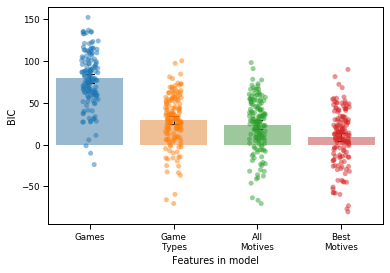

In [8]:
sns.set_context('paper')
fig,ax = plt.subplots(1,1,figsize = [6,4])
bar_order = ['Games', 'Game Types', 'All Motives', 'Best Motives']
xticklabels = ['\n'.join(a.split(' ')) for a in bar_order]

sns.barplot(data = all_model_fits_cleaned, x = 'model_descr', y = 'BIC', ax = ax, alpha = .5,
            order = bar_order, errcolor = 'k', capsize = .1, errwidth = 1)
sns.stripplot(data = all_model_fits_cleaned, x = 'model_descr', y = 'BIC', ax = ax, alpha = .5,
            order = bar_order)
# FigureTools.add_sig_markers(ax,relationships=[[2,3,0],[1,2,0]], distScale=.5, ystart = 30)
ax.set(ylabel = 'BIC', xlabel = 'Features in model',
      xticklabels = xticklabels);
# plt.savefig('/Users/jeroen/Desktop/modelcomp.pdf',transparent=True, bbox_inches = 'tight')

## Model comparison per subject - counts

In [9]:
def load_model_fits(date_string, features,
                    niter = 10, gaze = False, model_string = 'FeatureRL', fit_to = 'joint'):
    
    print(date_string, features)
    
    if model_string == "FeatureRL":
        model_fits = pd.read_csv(base_dir + 
             '/Data/Modeled/' +
             '%s_%s_%s_fitto-%s_gaze-%s_niter-%i.csv'%(
                 model_string,features,date_string, fit_to, gaze, niter),
               index_col = None, dtype={'sub_ID':str, 'comb':str, 'fit_to':str, 'sub_ind':int})
    elif model_string == "BayesianIO":
        model_fits = pd.read_csv(base_dir + 
             '/Data/Modeled/' +
             '%s_%s_fitto-%s_gaze-%s_niter-%i.csv'%(
                 model_string,date_string, fit_to, gaze, niter),
               index_col = 0, dtype={'subID':str, 'comb':str, 'fit_to':str, 'sub_ind':int})
        cost_type = model_fits['costType'].unique()
        if len(cost_type) > 1:
            raise ValueError('Multiple cost types detected - write code to deal with that')
        else:
            model_fits = model_fits.rename(columns = {'costVal':cost_type[0]})
    display(model_fits.head())
    print(model_fits.shape)
    return model_fits

In [10]:
model_fits = load_model_fits('2020-03-24','CoGrRiNa')

2020-03-24 CoGrRiNa


,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,feature_weight_1,feature_weight_2,feature_weight_3,feature_weight_4,cost_type,SSE,LL,BIC,model_type,features
0,1,2003,joint,1,0001,Nash,0,0,0,1.169,...,2.571,NaN,NaN,NaN,SSE,5.333,-11.414,35.305,FeatureRL,CoGrRiNa
1,1,2003,joint,2,0010,Risk,0,0,0,0.169,...,0.415,NaN,NaN,NaN,SSE,6.374,-17.113,46.702,FeatureRL,CoGrRiNa
2,1,2003,joint,3,0011,Risk_Nash,0,0,0,0.544,...,-1.963,5.234,NaN,NaN,SSE,5.641,-13.229,43.093,FeatureRL,CoGrRiNa
3,1,2003,joint,4,0100,Greed,0,0,0,0.855,...,2.636,NaN,NaN,NaN,SSE,3.581,1.077,10.323,FeatureRL,CoGrRiNa
4,1,2003,joint,5,0101,Greed_Nash,0,0,0,0.878,...,3.418,0.481,NaN,NaN,SSE,3.458,2.187,12.261,FeatureRL,CoGrRiNa


(2250, 23)


In [11]:
bestPerSubject = pd.DataFrame()
results_model_structure_requirement = model_fits.copy()
n_subs = len(results_model_structure_requirement['sub_ID'].unique())
for sub_ID in results_model_structure_requirement['sub_ID'].unique():
    sub_dat = results_model_structure_requirement.query('sub_ID == @sub_ID').copy()
    sub_dat = sub_dat.sort_values(by=['BIC','SSE'], ascending=True)
    bestPerSubject = bestPerSubject.append(sub_dat.iloc[0])
bestPerSubject = bestPerSubject.reset_index(drop=True)
bestModelCounts = pd.DataFrame(pd.value_counts(bestPerSubject.comb)).reset_index()
bestModelCounts.columns = ['comb','count']
bestModelCounts = bestModelCounts.sort_values(by='count', ascending=False)
bestPerSubject['nDim'] = [sum([char=='1' for 
                   char in bestPerSubject.comb.values[i]]) for i in np.arange(len(bestPerSubject))]
bestPerSubject['GatherS'] = bestPerSubject.feature_names.apply(lambda x: ('Risk' in x) | ('Nash' in x))
bestPerSubject['GatherT'] = bestPerSubject.feature_names.apply(lambda x: ('Greed' in x) | ('Nash' in x))
bestPerSubject['Complexity'] = bestPerSubject['GatherS'].astype(int) + bestPerSubject['GatherT'].astype(int)
bestModelnDimCounts = pd.DataFrame(pd.value_counts(bestPerSubject.nDim)).reset_index()
bestModelnDimCounts.columns = ['nDim','count']
bestModelComplexityCounts = pd.DataFrame(pd.value_counts(bestPerSubject.Complexity)).reset_index()
bestModelComplexityCounts.columns = ['Complexity','count']
bestModelComplexityCounts = bestModelComplexityCounts.sort_values(by='count', ascending=False)
display(bestModelComplexityCounts)
bestPerSubject.head()

,Complexity,count
0,1,85
1,2,63
2,0,2


,BIC,LL,LR_down,LR_up,SSE,asymm_LR,bounded_weights,comb,comb_index,cost_type,...,gaze,gaze_bias,inv_temp,model_type,sub_ID,sub_ind,nDim,GatherS,GatherT,Complexity
0,3.576,6.530,1.867,1.867,3.055,0.0,0.0,1100,12.0,SSE,...,0.0,0.0,0.154,FeatureRL,2003,1.0,2,False,True,1
1,23.122,-5.323,0.617,0.617,4.425,0.0,0.0,0100,4.0,SSE,...,0.0,0.0,0.253,FeatureRL,2015,10.0,1,False,True,1
2,-80.387,48.511,0.424,0.424,0.823,0.0,0.0,1100,12.0,SSE,...,0.0,0.0,0.256,FeatureRL,2135,100.0,2,False,True,1
3,7.377,4.629,1.359,1.359,3.242,0.0,0.0,1001,9.0,SSE,...,0.0,0.0,0.450,FeatureRL,2136,101.0,2,True,True,2
4,19.214,-1.289,0.932,0.932,3.901,0.0,0.0,1100,12.0,SSE,...,0.0,0.0,0.496,FeatureRL,2137,102.0,2,False,True,1


In [12]:
label_list = ['Coop.','Greed','Risk','Nash']
bestModelCounts['comb_labels'] = bestModelCounts['comb'].apply(lambda x: 
                ',\n'.join(label_list[k] for k in [i.span()[0] for i in re.finditer('1',x)]))
bestModelCounts['pct'] = bestModelCounts['count']/n_subs*100
bestModelComplexityCounts['pct'] = bestModelComplexityCounts['count']/n_subs*100
bestModelnDimCounts['pct'] = bestModelnDimCounts['count']/n_subs*100

In [13]:
n_models_in_plot = 8
bestModelCounts_trunc = bestModelCounts.iloc[:n_models_in_plot,:]
bestModelCounts_trunc

,comb,count,comb_labels,pct
0,1100,46,"Coop.,\nGreed",30.666667
1,0100,37,Greed,24.666667
2,1101,13,"Coop.,\nGreed,\nNash",8.666667
3,0101,12,"Greed,\nNash",8.000000
4,0110,9,"Greed,\nRisk",6.000000
5,0111,7,"Greed,\nRisk,\nNash",4.666667
6,1110,7,"Coop.,\nGreed,\nRisk",4.666667
7,1001,5,"Coop.,\nNash",3.333333


In [14]:
bmc_other = pd.DataFrame(bestModelCounts.iloc[n_models_in_plot:,:].sum()
                        ).T[['count','comb_labels','pct']]
bmc_other.loc[0,'comb_labels'] = 'other'
bestModelCounts_aggTrunc = bestModelCounts.iloc[:n_models_in_plot,:].append(
    bmc_other, sort = False)
bestModelCounts_aggTrunc

,comb,count,comb_labels,pct
0,1100,46,"Coop.,\nGreed",30.6667
1,0100,37,Greed,24.6667
2,1101,13,"Coop.,\nGreed,\nNash",8.66667
3,0101,12,"Greed,\nNash",8
4,0110,9,"Greed,\nRisk",6
5,0111,7,"Greed,\nRisk,\nNash",4.66667
6,1110,7,"Coop.,\nGreed,\nRisk",4.66667
7,1001,5,"Coop.,\nNash",3.33333
0,NaN,14,other,9.33333


In [15]:
bestModelnDimCounts

,nDim,count,pct
0,2,75,50.0
1,1,45,30.0
2,3,30,20.0


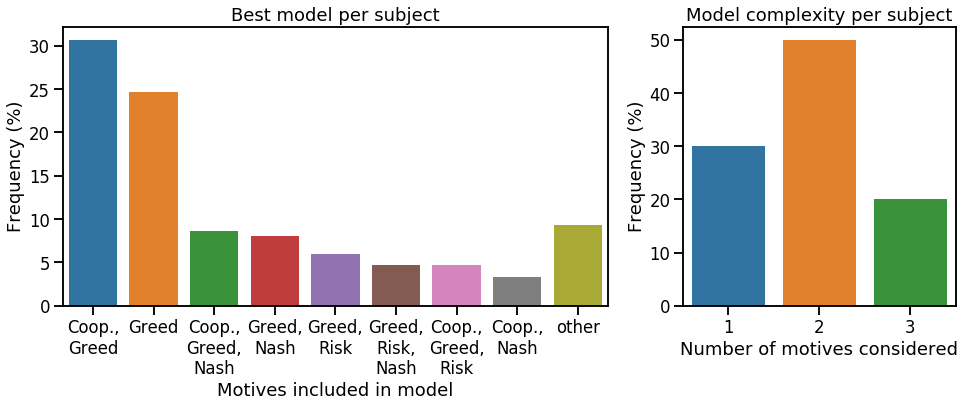

In [16]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [14,6],
                       gridspec_kw = {'width_ratios':[2,1]});
sns.barplot(data = bestModelCounts_aggTrunc, x='comb_labels', y='pct',
            order = bestModelCounts_aggTrunc.comb_labels, ax = ax[0],
           palette = 'tab10')
ax[0].set(xlabel = 'Motives included in model', ylabel = 'Frequency (%)',
       title = 'Best model per subject');
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=0)
sns.barplot(data = bestModelnDimCounts, x='nDim', y='pct', order = [1,2,3], ax = ax[1])
ax[1].set(xlabel = 'Number of motives considered', ylabel = 'Frequency (%)',
       title = 'Model complexity per subject');
plt.tight_layout()

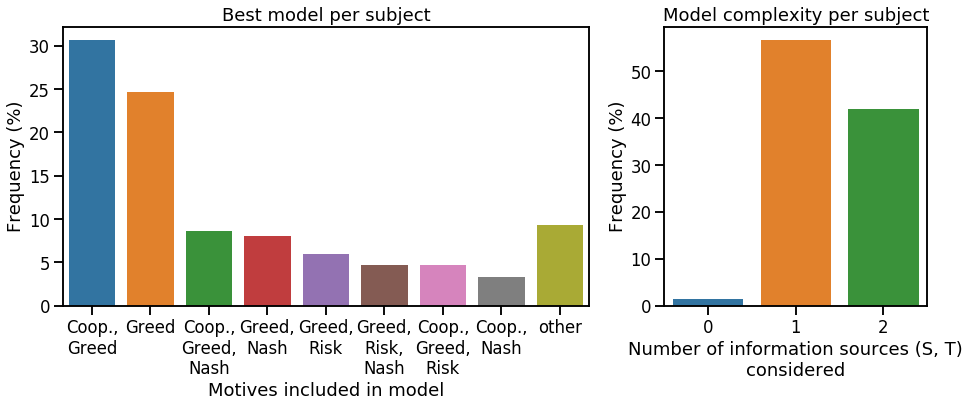

In [17]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [14,6], gridspec_kw = {'width_ratios':[2,1]});
sns.barplot(data = bestModelCounts_aggTrunc, x='comb_labels', y='pct',
            order = bestModelCounts_aggTrunc.comb_labels, ax = ax[0],
           palette = 'tab10')
ax[0].set(xlabel = 'Motives included in model', ylabel = 'Frequency (%)',
       title = 'Best model per subject');
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=0)
sns.barplot(data = bestModelComplexityCounts, x='Complexity', y='pct', order = [0,1,2], ax = ax[1])
ax[1].set(xlabel = 'Number of information sources (S, T)\nconsidered', ylabel = 'Frequency (%)',
       title = 'Model complexity per subject');
plt.tight_layout()

In [18]:
bestPerSubject_features = bestPerSubject.copy()
label_list = ['Coop.','Greed','Risk','Nash']
bestPerSubject_features['comb_labels'] = bestPerSubject_features['comb'].apply(lambda x: 
                ',\n'.join(label_list[k] for k in [i.span()[0] for i in re.finditer('1',x)]))
for feature in label_list:
    bestPerSubject_features[feature] = bestPerSubject_features['comb_labels'].apply(lambda x: feature in x)
bestPerSubject_features.head()

,BIC,LL,LR_down,LR_up,SSE,asymm_LR,bounded_weights,comb,comb_index,cost_type,...,sub_ind,nDim,GatherS,GatherT,Complexity,comb_labels,Coop.,Greed,Risk,Nash
0,3.576,6.530,1.867,1.867,3.055,0.0,0.0,1100,12.0,SSE,...,1.0,2,False,True,1,"Coop.,\nGreed",True,True,False,False
1,23.122,-5.323,0.617,0.617,4.425,0.0,0.0,0100,4.0,SSE,...,10.0,1,False,True,1,Greed,False,True,False,False
2,-80.387,48.511,0.424,0.424,0.823,0.0,0.0,1100,12.0,SSE,...,100.0,2,False,True,1,"Coop.,\nGreed",True,True,False,False
3,7.377,4.629,1.359,1.359,3.242,0.0,0.0,1001,9.0,SSE,...,101.0,2,True,True,2,"Coop.,\nNash",True,False,False,True
4,19.214,-1.289,0.932,0.932,3.901,0.0,0.0,1100,12.0,SSE,...,102.0,2,False,True,1,"Coop.,\nGreed",True,True,False,False


In [19]:
featureCounts = pd.DataFrame(bestPerSubject_features[label_list].sum()).reset_index()
featureCounts.columns = ['Motive','Count']
featureCounts['pct'] = featureCounts['Count']/n_subs
featureCounts.sort_values(by='Count', ascending = False, inplace=True)
featureCounts

,Motive,Count,pct
1,Greed,131,0.873333
0,Coop.,76,0.506667
3,Nash,47,0.313333
2,Risk,31,0.206667


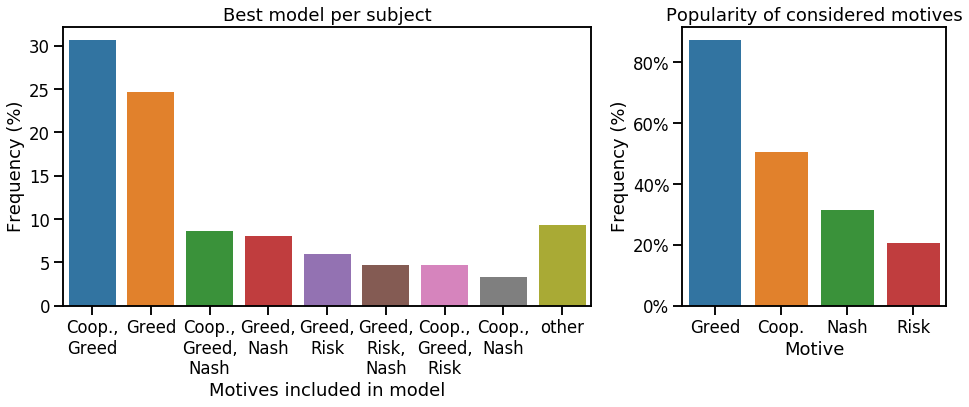

In [20]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [14,6], gridspec_kw = {'width_ratios':[2,1]});
sns.barplot(data = bestModelCounts_aggTrunc, x='comb_labels', y='pct',
            order = bestModelCounts_aggTrunc.comb_labels, ax = ax[0],
           palette = 'tab10')
ax[0].set(xlabel = 'Motives included in model', ylabel = 'Frequency (%)',
       title = 'Best model per subject');
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=0)
sns.barplot(data = featureCounts, x='Motive', y='pct', ax = ax[1])
ax[1].set(xlabel = 'Motive', ylabel = 'Frequency (%)',
       title = 'Popularity of considered motives');
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.tight_layout()

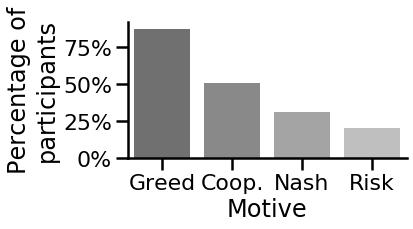

In [21]:
sns.set_context('poster')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [5,2.5]);
sns.barplot(data = featureCounts, x='Motive', y='pct', ax = ax,
           palette = sns.color_palette('Greys',10)[6:2:-1])
ax.set(xlabel = 'Motive', ylabel = 'Percentage of\nparticipants',
       title = None, yticks = [0,.25,.5,.75]);
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
sns.despine(top=True,right=True);

## Relationship between model features/complexity and performance

In [22]:
blockDat = gameDat[['subID','Type_Total','Type','Variant','ConfidenceNum','ScoreNum']
                  ].groupby(['subID','Type_Total','Type','Variant'], as_index=False).mean()
blockDat = blockDat.rename(columns={'ConfidenceNum':'Confidence','ScoreNum':'Score'})
subIDs = blockDat['subID'].unique()
print(len(subIDs))
blockDat.head()
blockDat = blockDat.rename(columns={'subID':'sub_ID'})

150


In [23]:
blockDat = blockDat.merge(bestPerSubject[['sub_ID','Complexity','nDim','comb']],on='sub_ID')
blockDat.head()

,sub_ID,Type_Total,Type,Variant,Confidence,Score,Complexity,nDim,comb
0,2003,opt_inv,opt,inv,50.625,0.4375,1,2,1100
1,2003,opt_nat,opt,nat,89.375,1.0000,1,2,1100
2,2003,pess_inv,pess,inv,50.000,0.5000,1,2,1100
3,2003,pess_nat,pess,nat,52.500,0.5625,1,2,1100
4,2004,opt_inv,opt,inv,53.125,0.2500,1,1,0100


##### Merge data for overall performance

In [24]:
totalDat = blockDat[['sub_ID','Confidence','Score']].groupby(['sub_ID']).mean().reset_index()
totalDat = totalDat.merge(bestPerSubject[['sub_ID','nDim','Complexity','comb']],on='sub_ID')
totalDat.head()

,sub_ID,Confidence,Score,nDim,Complexity,comb
0,2003,60.62500,0.62500,2,1,1100
1,2004,62.03125,0.50000,1,1,0100
2,2005,61.71875,0.53125,2,2,0101
3,2006,45.15625,0.56250,2,1,1100
4,2008,75.00000,0.59375,1,1,0100


##### Plot effect of n-dims:

SpearmanrResult(correlation=0.3498673320194501, pvalue=1.1405535790317253e-05)
F_onewayResult(statistic=10.519722233276298, pvalue=5.371532118317752e-05)


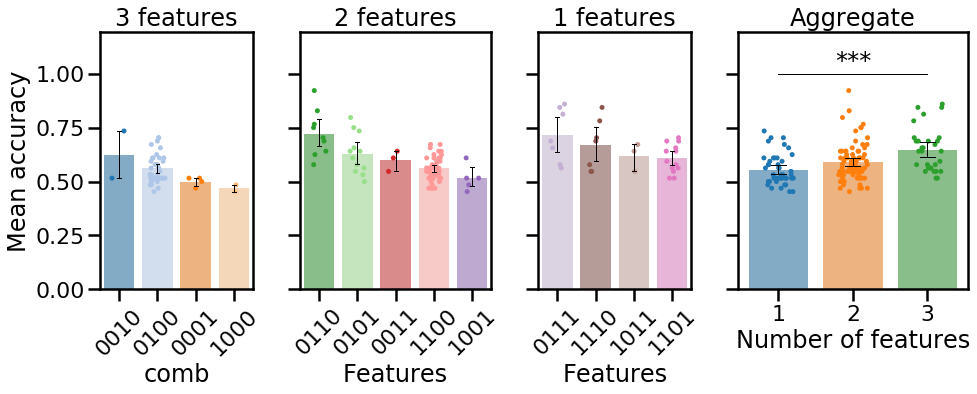

In [25]:
n_dims_list = [1,2,3]
panel_widths = [len(totalDat.query('nDim == @nDim')['comb'].unique()) for nDim in n_dims_list]
panel_widths.append(6)
fig, ax = plt.subplots(nrows = 1, ncols = len(n_dims_list)+1, figsize = [14,6], sharey=True,
                       gridspec_kw={'width_ratios':panel_widths});
nPast = 0
for ndi,nDim in enumerate(n_dims_list):
    nCombs = len(totalDat.query('nDim == @nDim')['comb'].unique())
    if nCombs > 1:
        means = totalDat.query('nDim == @nDim')[['comb','nDim','Score']].groupby(
            ['comb','nDim']).mean().sort_values(by='Score',ascending=False).reset_index()
        combOrder = list(means['comb'].values)
    else:
        combOrder = ['11100']
    sns.barplot(data = totalDat.query('nDim == @nDim'),
                y = 'Score', x='comb', ax=ax[ndi],
           alpha = .6, errwidth = 0, zorder = 0, order = combOrder,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    sns.stripplot(data = totalDat.query('nDim == @nDim'),
                  y = 'Score', x='comb', ax=ax[ndi],
           alpha = 1, zorder = 1, order = combOrder, size = 5, jitter = .2,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    sns.barplot(data = totalDat.query('nDim == @nDim'),
                y = 'Score', x='comb', ax=ax[ndi],
           alpha = 0, errwidth = 1, errcolor = 'k', capsize = .1, zorder = 2, order = combOrder,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    nPast = nPast + nCombs
    for tick in ax[ndi].get_xticklabels():
        tick.set_rotation(45)
ax[0].set(ylabel = 'Mean accuracy')
[ax[i].set(ylabel = '', xlabel = 'Features') for i in n_dims_list[::-1]]

sns.barplot(data = totalDat, x = 'nDim', y = 'Score', order = n_dims_list, ax = ax[len(n_dims_list)],
           alpha = .6, errwidth = 0, zorder = 0)
sns.stripplot(data = totalDat, x = 'nDim', y = 'Score', order = n_dims_list, ax = ax[len(n_dims_list)],
           alpha = 1, size = 5, jitter = .2, zorder = 1)
sns.barplot(data = totalDat, x = 'nDim', y = 'Score', order = n_dims_list, ax = ax[len(n_dims_list)],
           alpha = 0, errwidth = 1, errcolor = 'k', capsize = .2, zorder = 3)
[ax[i-1].set(title = '%i features'%((1+max(n_dims_list))-i)) for i in n_dims_list]
# ax[2].set(title = '1 feature')
ax[len(n_dims_list)].set(title = 'Aggregate', ylabel = '', xlabel = 'Number of features')

    
# Significant ranked trend?
spearman_results = scipy.stats.spearmanr(totalDat['nDim'],
                                         totalDat['Score'])
print(spearman_results)
print(scipy.stats.f_oneway(totalDat.query('nDim == 1')['Score'],
                     totalDat.query('nDim == 2')['Score'],
                    totalDat.query('nDim == 3')['Score']))

FigureTools.add_sig_markers(ax[len(n_dims_list)],relationships=[
    [0,len(n_dims_list)-1,spearman_results[1]]], caps = False, ystart = 1)
plt.tight_layout()

Aggregate only

SpearmanrResult(correlation=0.3498673320194501, pvalue=1.1405535790317253e-05)
F_onewayResult(statistic=10.519722233276298, pvalue=5.371532118317752e-05)
Group means +- sd:
1 dim: m = 55.49, sd 6.96
2 dim: m = 58.96, sd 8.78
3 dim: m = 64.79, sd 9.91


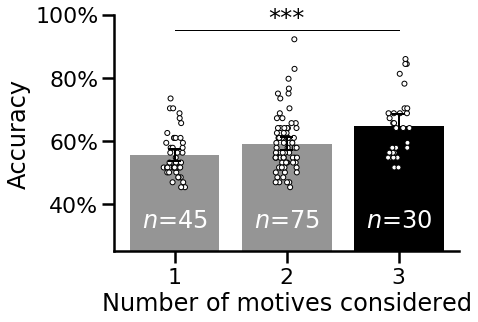

In [26]:
sns.set_context('poster')
n_dims_list = [1,2,3]
barcolors = [sns.color_palette('Greys',5)[i] for i in [2,2]]
barcolors.append([0,0,0])
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [7,5]);
sns.barplot(data = totalDat, x = 'nDim', y = 'Score', order = n_dims_list, ax = ax,
           alpha = 1, errwidth = 0, zorder = 0,
            palette = barcolors)
sns.stripplot(data = totalDat, x = 'nDim', y = 'Score', order = n_dims_list, ax = ax,
           alpha = 1, size = 5, jitter = .1, zorder = 1,
              palette = [[1,1,1] for i in [2,2,2]], edgecolor = 'k', linewidth = 1)
sns.barplot(data = totalDat, x = 'nDim', y = 'Score', order = n_dims_list, ax = ax,
           alpha = 0, errwidth = 2, errcolor = 'k', capsize = .1, zorder = 3)


# Significant ranked trend?
spearman_results = scipy.stats.spearmanr(totalDat['nDim'],
                                         totalDat['Score'])
print(spearman_results)
print(scipy.stats.f_oneway(totalDat.query('nDim == 1')['Score'],
                     totalDat.query('nDim == 2')['Score'],
                    totalDat.query('nDim == 3')['Score']))
print('Group means +- sd:')
for ndim in [1,2,3]:
    m_sd = [fun(totalDat.query('nDim == %i'%ndim)['Score'].values) for fun in [np.mean,np.std]]
    print('%i dim: m = %.2f, sd %.2f'%(ndim, m_sd[0]*100, m_sd[1]*100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

FigureTools.add_sig_markers(ax,relationships=[
    [0,len(n_dims_list)-1,spearman_results[1]]], caps = False, ystart = .95)

ax.set(xlabel = 'Number of motives considered', ylabel = 'Accuracy', title = None,
      ylim = [0.25,1])
sns.despine(top=True, right = True)

for i in [1,2,3]:
    ax.text(i-1,.35,'$n$=%i'%totalDat['nDim'].value_counts()[i],
           fontdict = {'horizontalalignment':'center','verticalalignment':'center',
                      'color':'white'})

plt.tight_layout()

In [27]:
def ttest_1samp(dat, popmean = .5, verbose = True):
    if verbose:
        print('SD: ',np.std(dat))
        print('Stats:')
    stats = scipy.stats.ttest_1samp(dat, popmean = popmean)
    if verbose:
        print(stats)
        print('Cohen d:')
    coh_d = (np.mean(dat) - popmean)/np.std(dat)
    if verbose:
        print(coh_d)
    return(stats, coh_d)

def ttest_2samp(dat1, dat2):
    print('SD dat 1: ',np.std(dat1))
    print('SD dat 2: ',np.std(dat2))
    print('Stats:')
    stats = scipy.stats.ttest_ind(dat1, dat2)
    print(stats)
    print('Cohen d:')
    nx = len(dat1)
    ny = len(dat2)
    dof = nx + ny - 2
    coh_d = ((np.mean(dat1) - np.mean(dat2)) /
             np.sqrt(((nx-1)*np.std(dat1, ddof=1) ** 2 + (ny-1)*np.std(dat2, ddof=1) ** 2) / dof))
    print(coh_d)
    return(stats, coh_d)

In [28]:
# Pairwise t-tests
ndim1 = 2; ndim2 = 1;
dat1 = totalDat.query('nDim == %i'%ndim1)['Score'];
dat2 = totalDat.query('nDim == %i'%ndim2)['Score'];
stats = ttest_2samp(dat1,dat2)
print(len(dat1)+len(dat2))
print(stats)

print('\n\n\n\n')

ndim1 = 3; ndim2 = 2;
dat1 = totalDat.query('nDim == %i'%ndim1)['Score'];
dat2 = totalDat.query('nDim == %i'%ndim2)['Score'];
stats = ttest_2samp(dat1,dat2)
print(len(dat1)+len(dat2))
print(stats)

SD dat 1:  0.08777239347058706
SD dat 2:  0.06961437542226533
Stats:
Ttest_indResult(statistic=2.2421872379859473, pvalue=0.026817679416952206)
Cohen d:
0.4227908801786129
120
(Ttest_indResult(statistic=2.2421872379859473, pvalue=0.026817679416952206), 0.4227908801786129)





SD dat 1:  0.099128143778086
SD dat 2:  0.08777239347058706
Stats:
Ttest_indResult(statistic=2.933773726320993, pvalue=0.004128289853703749)
Cohen d:
0.6337675596029382
105
(Ttest_indResult(statistic=2.933773726320993, pvalue=0.004128289853703749), 0.6337675596029382)


## Relationship between model features/complexity and response time

##### Compute overall log response time

In [29]:
RTchoices = ['RT_radio','RT_submit']
#
RTdat = gameDat[['subID','Type_Total','phase','RT_radio','RT_submit']
                   ].groupby(['subID']).mean().reset_index()
RTdat = RTdat.merge(bestPerSubject[['sub_ID','nDim','Complexity','comb']],
                    left_on='subID', right_on = 'sub_ID')
for rci, RTchoice in enumerate(RTchoices):
    RTuse = 'log_%s'%RTchoice
    RTdat[RTuse] = np.log(RTdat[RTchoice] / 1000)
display(RTdat.head())
#
RTdat_splitPhase = gameDat[['subID','Type_Total','phase','RT_radio','RT_submit']
                   ].groupby(['subID','phase']).mean().reset_index()
RTdat_splitPhase = RTdat_splitPhase.merge(bestPerSubject[['sub_ID','nDim','Complexity','comb']],
                    left_on='subID', right_on = 'sub_ID')
for rci, RTchoice in enumerate(RTchoices):
    RTuse = 'log_%s'%RTchoice
    RTdat_splitPhase[RTuse] = np.log(RTdat_splitPhase[RTchoice] / 1000)
display(RTdat_splitPhase.head())

,subID,RT_radio,RT_submit,sub_ID,nDim,Complexity,comb,log_RT_radio,log_RT_submit
0,2003,3856.203125,6790.265625,2003,2,1,1100,1.349683,1.915490
1,2004,5184.656250,7150.828125,2004,1,1,0100,1.645704,1.967228
2,2005,5697.796875,8349.546875,2005,2,2,0101,1.740080,2.122207
3,2006,5037.125000,6764.031250,2006,2,1,1100,1.616835,1.911619
4,2008,8875.156250,10935.531250,2008,1,1,0100,2.183256,2.392017


,subID,phase,RT_radio,RT_submit,sub_ID,nDim,Complexity,comb,log_RT_radio,log_RT_submit
0,2003,early,4567.50000,7645.90625,2003,2,1,1100,1.518966,2.034170
1,2003,late,3144.90625,5934.62500,2003,2,1,1100,1.145784,1.780804
2,2004,early,5741.68750,8089.28125,2004,1,1,0100,1.747753,2.090540
3,2004,late,4627.62500,6212.37500,2004,1,1,0100,1.532044,1.826543
4,2005,early,5608.03125,8732.46875,2005,2,2,0101,1.724200,2.167048


##### First test early-late RT diff

(array([ 1.,  2.,  3.,  5., 17., 47., 61., 10.,  3.,  1.]),
 array([-2.23378725, -1.8979221 , -1.56205694, -1.22619179, -0.89032663,
        -0.55446148, -0.21859633,  0.11726883,  0.45313398,  0.78899914,
         1.12486429]),
 <a list of 10 Patch objects>)

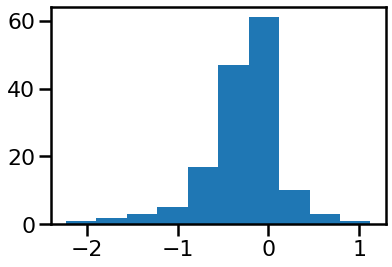

In [30]:
rt_phase_diff = RTdat_splitPhase.pivot('subID', 'phase', 'log_RT_radio').reset_index()
rt_phase_diff['diff'] = rt_phase_diff['late'] - rt_phase_diff['early']
plt.hist(rt_phase_diff['diff'])

In [31]:
scipy.stats.normaltest(rt_phase_diff['diff'])

NormaltestResult(statistic=50.675508948677596, pvalue=9.907248308185601e-12)

In [32]:
scipy.stats.wilcoxon(rt_phase_diff['diff'])

WilcoxonResult(statistic=1245.0, pvalue=1.1489021711418737e-16)

In [33]:
ttest_1samp(rt_phase_diff['diff'], 0)

SD:  0.42639946372104104
Stats:
Ttest_1sampResult(statistic=-8.237211337988368, pvalue=8.299819559676345e-14)
Cohen d:
-0.6748186464141427


(Ttest_1sampResult(statistic=-8.237211337988368, pvalue=8.299819559676345e-14),
 -0.6748186464141427)

##### Plot

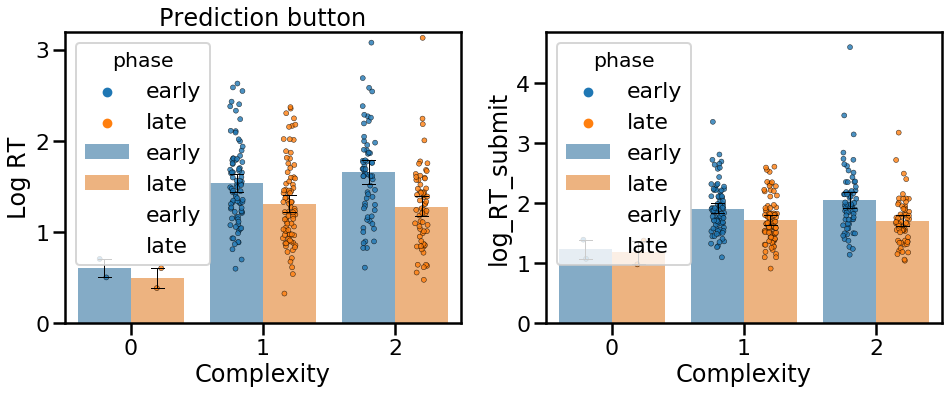

In [34]:
fig, ax = plt.subplots(1,2,figsize=[14,6])
x_name = 'Complexity'
x_list = RTdat[x_name].unique().tolist()
x_list.sort()
hue_name = 'phase'
if hue_name == 'phase':
    plot_dat = RTdat_splitPhase
else:
    plot_dat = RTdat

for rci, RTchoice in enumerate(RTchoices):
    RTuse = 'log_%s'%RTchoice
    sns.barplot(data = plot_dat,
                ax = ax[rci],
           hue = hue_name, 
                y = RTuse, x = x_name, order = x_list,
           hue_order = ['early','late'],
           capsize=.1, errwidth = 0, errcolor = 'k', alpha = .6, zorder = 0)
    sns.stripplot(data = plot_dat,
                ax = ax[rci],
           hue = hue_name, 
                  y = RTuse, x = x_name, order = x_list,
           hue_order = ['early','late'],
           dodge=True, edgecolor = 'k', linewidth=.5, alpha = .8, zorder = 1)
    sns.barplot(data = plot_dat,
                ax = ax[rci],
           hue = hue_name, 
                y = RTuse, x = x_name, order = x_list,
           hue_order = ['early','late'],
           capsize=.1, errwidth = 1, errcolor = 'k', alpha = 0, zorder = 2)
    if hue_name is None:
        print(scipy.stats.f_oneway(*[plot_dat.query('%s == @i'%x_name)[RTchoice] for i in x_list]))
    else:
        if rci == 0:
            [hand,lab] = ax[rci].get_legend_handles_labels()
ax[0].set(ylabel = 'Log RT', ylim = [0,3.2],
         xlabel = x_name, title = 'Prediction button')
plt.tight_layout()

##### RT radio button only:

In [35]:
x_name = 'Complexity'
x_list = RTdat[x_name].unique().tolist()
x_list.sort()
RTchoice = 'RT_radio'
RTuse = 'log_%s'%RTchoice

F_onewayResult(statistic=2.3031822995089923, pvalue=0.10172277238729874)
Ttest_indResult(statistic=2.0997307709334505, pvalue=0.03747270043217071)


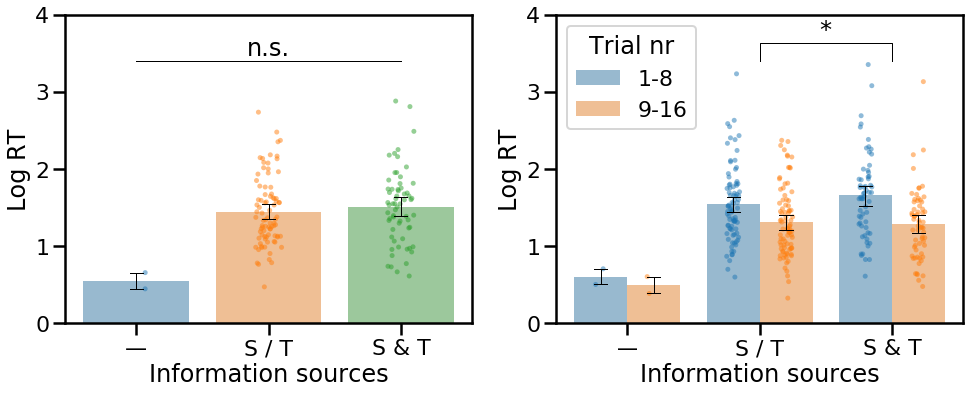

In [36]:
fig, ax = plt.subplots(1,2,figsize=[14,6])

# Plot log mean RT per subject
sns.barplot(data = RTdat, ax = ax[0],
            y = RTuse, x = x_name, order = x_list,
            capsize=.1, errwidth = 0, errcolor = 'k', alpha = .5, zorder = 0)
sns.stripplot(data = RTdat, ax = ax[0],
            y = RTuse, x = x_name, order = x_list,
            dodge=True, edgecolor = 'k', linewidth=0, alpha = .5, zorder = 1)
sns.barplot(data = RTdat, ax = ax[0],
            y = RTuse, x = x_name, order = x_list,
            capsize=.1, errwidth = 1, errcolor = 'k', alpha = 0, zorder = 2)
# F-test
f_result = scipy.stats.f_oneway(*[plot_dat.query('%s == @i'%x_name)[RTchoice] for i in x_list])
print(f_result)
FigureTools.add_sig_markers(ax[0], relationships=[[0,2,f_result[1]]],
                           caps = False, ystart = 3.4)
# Axes
ax[0].set(ylabel = 'Log RT', ylim = [0,4], xlabel = 'Information sources',
         xticklabels = ['—','S / T','S & T'])

# Plot log mean RT per subject
sns.barplot(data = RTdat_splitPhase, ax = ax[1],
            hue = 'phase',
            y = RTuse, x = x_name, order = x_list,
            capsize=.1, errwidth = 0, errcolor = 'k', alpha = .5, zorder = 0)
[hand,lab] = ax[1].get_legend_handles_labels()
sns.stripplot(data = RTdat_splitPhase, ax = ax[1],
              hue = 'phase',
            y = RTuse, x = x_name, order = x_list,
            dodge=True, edgecolor = 'k', linewidth=0, alpha = .5, zorder = 1)
sns.barplot(data = RTdat_splitPhase, ax = ax[1],
            y = RTuse, x = x_name, order = x_list,
            hue = 'phase',
            capsize=.1, errwidth = 1, errcolor = 'k', alpha = 0, zorder = 2)
# T-test
comp2_late_v_early = (RTdat_splitPhase.query('Complexity == 2 and phase == "late"').log_RT_radio.values
            - RTdat_splitPhase.query('Complexity == 2 and phase == "early"').log_RT_radio.values)
comp1_late_v_early = (RTdat_splitPhase.query('Complexity == 1 and phase == "late"').log_RT_radio.values
            - RTdat_splitPhase.query('Complexity == 1 and phase == "early"').log_RT_radio.values)
ttest_result_diff_scores_comp2_vs_comp1 = scipy.stats.ttest_ind(
    comp1_late_v_early, comp2_late_v_early)
print(ttest_result_diff_scores_comp2_vs_comp1)

FigureTools.add_sig_markers(ax[1],
            relationships=[[1,2,ttest_result_diff_scores_comp2_vs_comp1[1]]],
           caps = 0.2, ystart = 3.4)
# Axes
ax[1].set(ylabel = 'Log RT', ylim = [0,4], xlabel = 'Information sources',
         xticklabels = ['—','S / T','S & T'])
plt.legend(hand,['1-8','9-16'],loc='upper left', title = 'Trial nr')
plt.tight_layout()

In [37]:
ttest_2samp(comp1_late_v_early, comp2_late_v_early)

SD dat 1:  0.36874008650356177
SD dat 2:  0.4855508611807448
Stats:
Ttest_indResult(statistic=2.0997307709334505, pvalue=0.03747270043217071)
Cohen d:
0.34907177378979254


(Ttest_indResult(statistic=2.0997307709334505, pvalue=0.03747270043217071),
 0.34907177378979254)

In [38]:
f_dat = [RTdat_splitPhase.query('phase == "early" and Complexity == @i')[RTuse].values for i in [0,1,2]]

In [39]:
len(f_dat[1])+len(f_dat[2])

148

In [40]:
scipy.stats.f_oneway(*f_dat)

F_onewayResult(statistic=4.635877100443041, pvalue=0.011158563500883604)

In [41]:
print(scipy.stats.normaltest(f_dat[1]))
print(scipy.stats.normaltest(f_dat[2]))

NormaltestResult(statistic=11.484870386809414, pvalue=0.0032069492171286637)
NormaltestResult(statistic=6.581949667706261, pvalue=0.03721755077810039)


In [42]:
print(scipy.stats.mannwhitneyu(f_dat[0],f_dat[1]))
print(scipy.stats.mannwhitneyu(f_dat[1],f_dat[2]))

MannwhitneyuResult(statistic=2.0, pvalue=0.009730779955491537)
MannwhitneyuResult(statistic=2309.5, pvalue=0.07704984853636543)


In [43]:
RT_LMER_dat = RTdat_splitPhase.copy()
RT_LMER_dat.head()

,subID,phase,RT_radio,RT_submit,sub_ID,nDim,Complexity,comb,log_RT_radio,log_RT_submit
0,2003,early,4567.50000,7645.90625,2003,2,1,1100,1.518966,2.034170
1,2003,late,3144.90625,5934.62500,2003,2,1,1100,1.145784,1.780804
2,2004,early,5741.68750,8089.28125,2004,1,1,0100,1.747753,2.090540
3,2004,late,4627.62500,6212.37500,2004,1,1,0100,1.532044,1.826543
4,2005,early,5608.03125,8732.46875,2005,2,2,0101,1.724200,2.167048


##### Plot split only

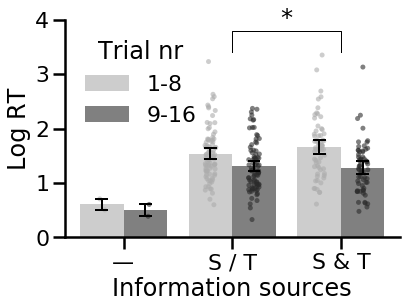

In [44]:
fig, ax = plt.subplots(1,1,figsize=[6,4])

sns.barplot(data = RTdat_splitPhase, ax = ax,
            hue = 'phase', y = RTuse, x = x_name, order = x_list,
            capsize=.1, errwidth = 0, errcolor = 'k', alpha = .6, zorder = 0,
           palette = [sns.color_palette('Greys',6)[i] for i in [2,5]])
[hand,lab] = ax.get_legend_handles_labels()
sns.stripplot(data = RTdat_splitPhase, ax = ax,
              hue = 'phase', y = RTuse, x = x_name, order = x_list,
            dodge=True, edgecolor = 'k', linewidth=0, alpha = .6, zorder = 1,
             palette = [sns.color_palette('Greys',6)[i] for i in [2,5]], size = 5)
sns.barplot(data = RTdat_splitPhase, ax = ax,
            y = RTuse, x = x_name, order = x_list,
            hue = 'phase', capsize=.1, errwidth = 2, errcolor = 'k', alpha = 0, zorder = 2)
FigureTools.add_sig_markers(ax,
            relationships=[[1,2,ttest_result_diff_scores_comp2_vs_comp1[1]]],
           caps = 0.2, ystart = 3.4)
# Axes
ax.set(ylabel = 'Log RT', ylim = [0,4], xlabel = 'Information sources',
         xticklabels = ['—','S / T','S & T'])
plt.legend(hand,['1-8','9-16'],loc='upper left', title = 'Trial nr',
          frameon=False)

sns.despine(top=True, right = True)

In [45]:
linedat = RTdat_splitPhase.groupby(['Complexity','phase']).mean()[RTuse]

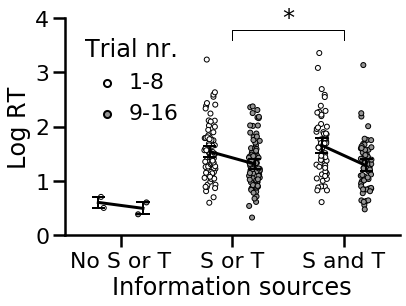

In [46]:
fig, ax = plt.subplots(1,1,figsize=[6,4])
barcolors = [[1,1,1],sns.color_palette('Greys',5)[2]]
# barcolors.append([0,0,0])

# sns.barplot(data = RTdat_splitPhase, ax = ax,
#             hue = 'phase', y = RTuse, x = x_name, order = x_list,
#             capsize=.1, errwidth = 0, errcolor = 'k', alpha = 0, zorder = 0,
#            palette = barcolors)
# [hand,lab] = ax.get_legend_handles_labels()
sns.stripplot(data = RTdat_splitPhase, ax = ax,
              hue = 'phase', y = RTuse, x = x_name, order = x_list,
            dodge=True, edgecolor = 'k', linewidth=1, alpha = 1, zorder = 1,
             palette = barcolors, size = 5)
[hand,lab] = ax.get_legend_handles_labels()
sns.barplot(data = RTdat_splitPhase, ax = ax,
            y = RTuse, x = x_name, order = x_list,
            hue = 'phase', capsize=.1, errwidth = 2, errcolor = 'k', alpha = 0, zorder = 2)
FigureTools.add_sig_markers(ax,
            relationships=[[1,2,ttest_result_diff_scores_comp2_vs_comp1[1]]],
            ystart = 3.6, distScale = .5, interact_caps=True)
linedat = RTdat_splitPhase.groupby(['Complexity','phase']).mean()[RTuse]
for comp in [0,1,2]:
    ax.plot([comp-.2,comp+.2],linedat[comp].values,'k-')
    
# Axes
ax.set(ylabel = 'Log RT', ylim = [0,4], xlim = [-.5,2.5], xlabel = 'Information sources',
         xticklabels = ['No S or T','S or T','S and T'])
ax.get_legend().remove()
scat1 = ax.scatter([5],[3], 50, [barcolors[0]], edgecolors = 'k', linewidths = 2)
scat2 = ax.scatter([5],[3], 50, [barcolors[1]], edgecolors = 'k', linewidths = 2)

plt.legend((scat1,scat2), ['1-8','9-16'],handletextpad=0,
           loc='upper left', title = 'Trial nr.',
          frameon=False)

sns.despine(top=True, right = True)